# Classification

In [71]:
!pip install xgboost
!pip install delayed
#you'll need to install these libraries incase you haven't already

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from numpy import where
from numpy import meshgrid
from numpy import arange
from numpy import hstack
from numpy import std
from numpy import mean

from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv("bankruptcy.csv")
data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


0    6599
1     220
Name: Bankrupt?, dtype: int64


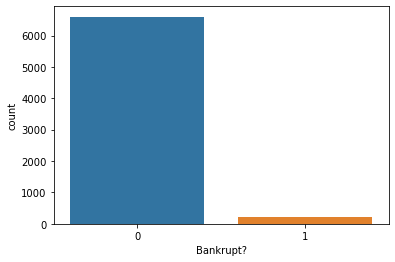

In [3]:
print(data['Bankrupt?'].value_counts())
sns.countplot(x='Bankrupt?',data=data)

#from the plot here we can see its a highly skewed data

In [4]:
#look for null values

data.isna().sum().sum()

0

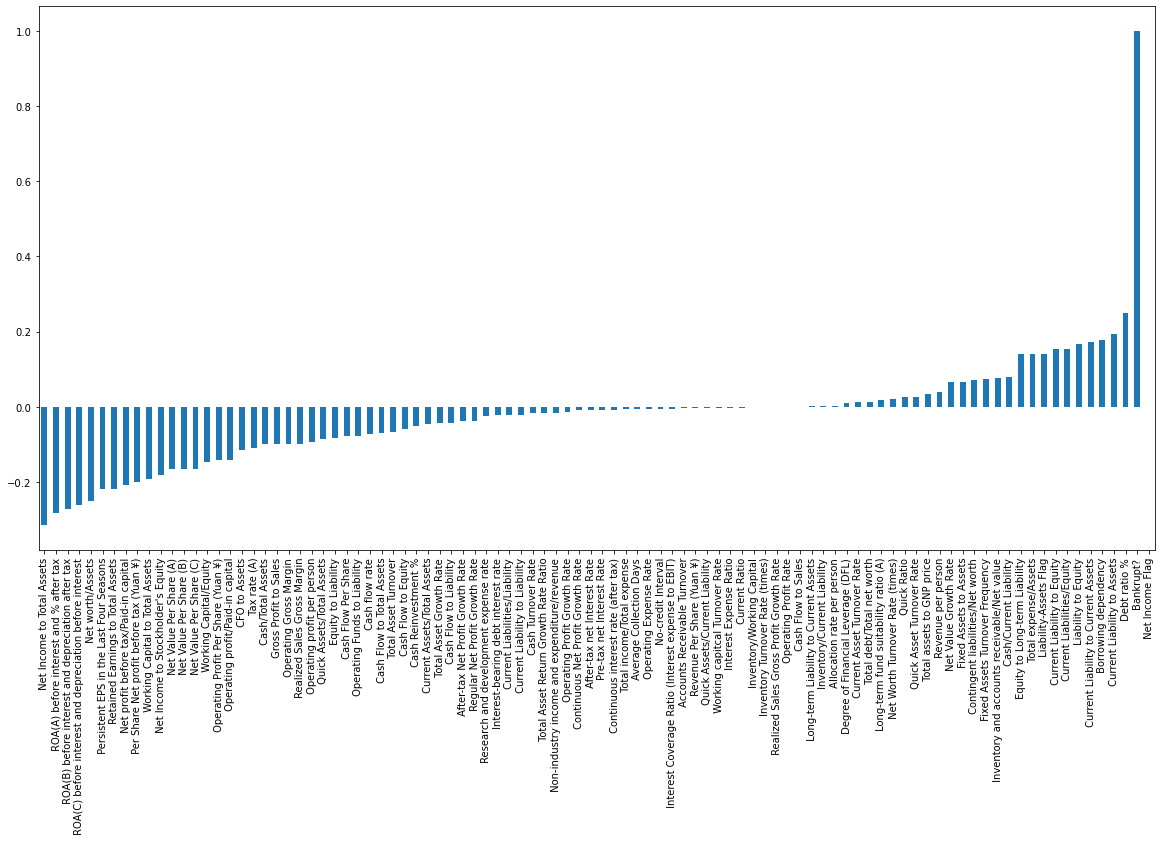

In [5]:
#plot the correlation graph

'''we didn't do pair plot and heatmap because we have 96 features -- which is too many and it wouldn't make sense
'''
plt.figure(figsize=(20,10))
data.corr()['Bankrupt?'][:].sort_values().plot(kind='bar')

In [6]:
#filter out features with a correlation taregt less than 0.2

cor_target = abs(data.corr()['Bankrupt?'])
set_features = cor_target[cor_target > 0.2]
print(set_features)

Bankrupt?                                                   1.000000
 ROA(C) before interest and depreciation before interest    0.260807
 ROA(A) before interest and % after tax                     0.282941
 ROA(B) before interest and depreciation after tax          0.273051
 Persistent EPS in the Last Four Seasons                    0.219560
 Per Share Net profit before tax (Yuan ¥)                   0.201395
 Debt ratio %                                               0.250161
 Net worth/Assets                                           0.250161
 Net profit before tax/Paid-in capital                      0.207857
 Retained Earnings to Total Assets                          0.217779
 Net Income to Total Assets                                 0.315457
Name: Bankrupt?, dtype: float64


In [7]:
data = data[set_features.index]
data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Debt ratio %,Net worth/Assets,Net profit before tax/Paid-in capital,Retained Earnings to Total Assets,Net Income to Total Assets
0,1,0.370594,0.424389,0.405750,0.169141,0.138736,0.207576,0.792424,0.137757,0.903225,0.716845
1,1,0.464291,0.538214,0.516730,0.208944,0.169918,0.171176,0.828824,0.168962,0.931065,0.795297
2,1,0.426071,0.499019,0.472295,0.180581,0.142803,0.207516,0.792484,0.148036,0.909903,0.774670
3,1,0.399844,0.451265,0.457733,0.193722,0.148603,0.151465,0.848535,0.147561,0.906902,0.739555
4,1,0.465022,0.538432,0.522298,0.212537,0.168412,0.106509,0.893491,0.167461,0.913850,0.795016
...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.216602,0.172102,0.124618,0.875382,0.171111,0.925611,0.799927
6815,0,0.475162,0.538269,0.524172,0.216697,0.172780,0.099253,0.900747,0.171805,0.932629,0.799748
6816,0,0.472725,0.533744,0.520638,0.210929,0.173232,0.038939,0.961061,0.172287,0.932000,0.797778
6817,0,0.506264,0.559911,0.554045,0.228326,0.185584,0.086979,0.913021,0.182498,0.939613,0.811808


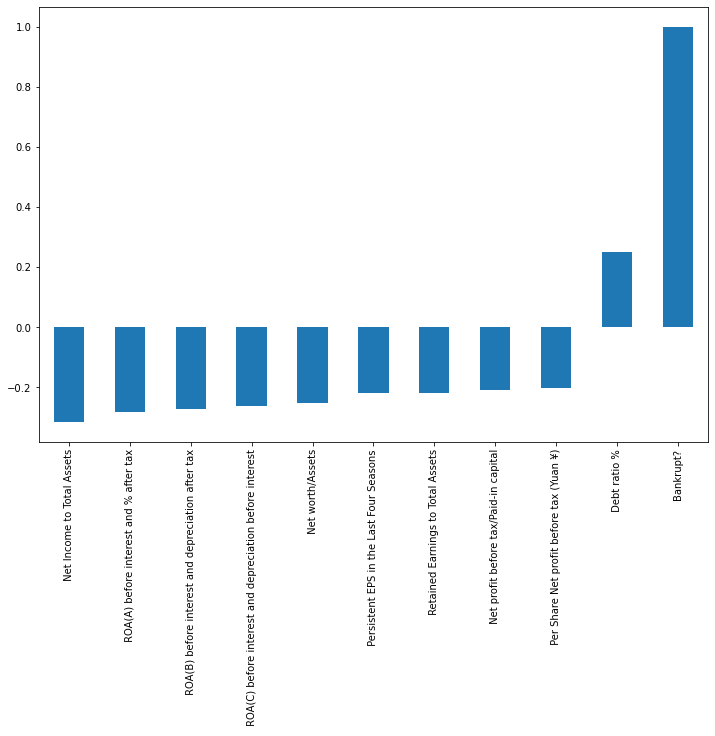

In [8]:
#rechecking their correlation values with a bar plot

plt.figure(figsize=(12,8))
data.corr()['Bankrupt?'][:].sort_values().plot(kind='bar')

In [9]:
#replacing column names who have spaces with underscores

data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
# data

In [10]:
# '''
# by the Z-score we re-scale and center the data and look for data points which are too far from zero. 
# These data points will be treated as the outliers. 
# In most of the cases a threshold of 3 or -3 is used;
# if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

# '''
# z_scores = stats.zscore(data)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# data = data[filtered_entries]
# data

In [11]:
data.isna().sum().sum()

0

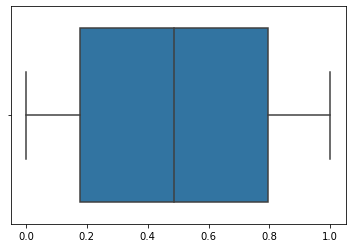

In [12]:
#after the above preprocessings we can see the boxplot is fairly symmetrical

sns.boxplot(x=data[(i for i in data.columns)])

In [13]:
X = data.drop('bankrupt?',axis=1).values
y = data['bankrupt?'].values

#Split the dataset into 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


#Do oversampling for the train set using SMOTE because its highly skewed

smn = SMOTEENN()


print("Counts before SMOTE")
print(Counter(y_train))

X_res,y_res = smn.fit_resample(X_train,y_train)
print("Counts after SMOTE")
print(Counter(y_res))

Counts before SMOTE
Counter({0: 5280, 1: 175})
Counts after SMOTE
Counter({1: 5128, 0: 4499})


In [14]:
# #scaler
# sc_X = StandardScaler()
# X_res = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)

# #Get the original X_test
# X_test_orig = sc_X.inverse_transform(X_test)
# display(pd.DataFrame(X_test_orig))

In [15]:
# Evaluation using cross validation
def eval_cv(classifier, metric):
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # evaluate model
    scores = cross_val_score(classifier, X, y, scoring=metric, cv=cv, n_jobs=-1)
    # report performance
    return mean(scores)

In [16]:
# Calculate the metrics
def calculate_metrics(df, method):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 16})
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    df.loc[method] = [accuracy, precision, recall, f1, auc]

In [17]:
# Do the the cross validation of all metrics
def calculate_cv(df, classifier, method):
    accuracy = eval_cv(classifier, 'accuracy')
    precision = eval_cv(classifier, 'precision')
    recall = eval_cv(classifier, 'recall')
    f1 = eval_cv(classifier, 'f1')
    auc = eval_cv(classifier, 'roc_auc')
    df.loc[method] = [accuracy, precision, recall, f1, auc]    

In [18]:
# included methods/models and metrics
methods = ['XGBClassifier', 'LogisticRegression', 'Linear SVM']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'ROC AUC']

# create model quality dataframe
quality_df = pd.DataFrame(columns = metrics, index = methods)
display(quality_df)

# create model quality cross validation dataframe
quality_cv_df = pd.DataFrame(columns = metrics, index = methods)
display(quality_cv_df)

,Accuracy,Precision,Recall,F1 score,ROC AUC
XGBClassifier,NaN,NaN,NaN,NaN,NaN
LogisticRegression,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
XGBClassifier,NaN,NaN,NaN,NaN,NaN
LogisticRegression,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
XGBClassifier,0.892229,0.206897,0.8,0.328767,0.847688
LogisticRegression,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN


KeyboardInterrupt: 

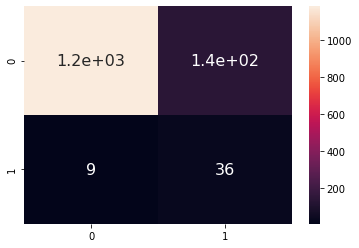

In [19]:
#Algorithm: XGBClassifier 

classifier = XGBClassifier(objective= 'binary:logistic', eval_metric='error', max_depth = 8,max_delta_step=1,
                           learning_rate= 0.0003, n_estimators=6000,subsample=0.5,
                           use_label_encoder=False)

classifier.fit(X_res, y_res)
y_pred = classifier.predict(X_test)

#accuracy = metrics.accuracy_score(y_test, y_pred)

# Evaluate the model
method = 'XGBClassifier'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

,Accuracy,Precision,Recall,F1 score,ROC AUC
XGBClassifier,NaN,NaN,NaN,NaN,NaN
LogisticRegression,0.894428,0.210526,0.8,0.333333,0.848825
Linear SVM,NaN,NaN,NaN,NaN,NaN


KeyboardInterrupt: 

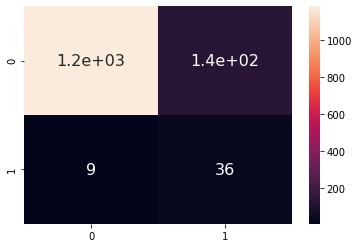

In [103]:
#Algorithm: LogisticRegression 

logmodel = LogisticRegression(C=3.0, max_iter=1000)
logmodel.fit(X_res,y_res)
predictions = logmodel.predict(X_test)
#accuracy = metrics.accuracy_score(y_test, predictions)

# Evaluate the model
method = 'LogisticRegression'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#Algorithm: Support Vector Machines 

model = svm.SVC(kernel='linear')

model.fit(X_res, y_res)
#acc = model.score(X_test, y_test)

method = 'Linear SVM'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))